In [4]:
import sys
sys.path.append('../src')

from DatasetGeneration.DataGenerator.utils2 import save_kde, load_kde, TruncatedKDE
from particle import Particle
import uproot
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import cv2
import os

In [5]:
# Read the full-montecarlo data
f_c = uproot.open('DatasetGeneration/full-MC/RichHitsTuple_v2.root')
t_c = f_c['RICH/RichRecoTuple/RichRecoTuple']
df_c = t_c.arrays(library='pd')
df_c.head(3)

file = uproot.open('DatasetGeneration/full-MC/RichHitsTuple_v2.root')
tree = file['RICH/RichRecoTuple/RichRecoTuple']
print(tree.keys())

'''

- nHits è il numero di hits per evento
- pixelXglo_R1 e pixelYglo_R1 sono le coordinate globali degli hits nel primo rivelatore (e quindi la lunghezza della lista è nHits)
- nCtrs è il numero di centri degli anelli Cherenkov per evento
- Ctr_xLoc_R1 e Ctr_yLoc_R1 sono le coordinate globali dei centri degli anelli Cherenkov nel primo rivelatore (e quindi la lunghezza della lista è nCtrs)
- idem per R2 (RICH2)
- poi ci sono le stesse coordinate ma locali, quindi pixelXloc_R1, pixelYloc_R1, Ctr_xLoc_R1, Ctr_yLoc_R1, ecc.
 
'''

['nHits_R1', 'pixelXglo_R1', 'pixelYglo_R1', 'pixelXloc_R1', 'pixelYloc_R1', 'nHits_R2', 'pixelXglo_R2', 'pixelYglo_R2', 'pixelXloc_R2', 'pixelYloc_R2', 'nMCP', 'MCP_PX', 'MCP_PY', 'MCP_PZ', 'MCP_ID', 'MCP_charge', 'MCP_PVX', 'MCP_PVY', 'MCP_PVZ', 'MCP_OVX', 'MCP_OVY', 'MCP_OVZ', 'MCP_RecType', 'nTRK', 'TRK_PX', 'TRK_PY', 'TRK_PZ', 'TRK_charge', 'TRK_chi2ndof', 'TRK_GP', 'TRK_ndof', 'TRK_MCPIDX', 'nCtrsR1', 'Ctr_xLoc_R1', 'Ctr_yLoc_R1', 'nCtrsR2', 'Ctr_xLoc_R2', 'Ctr_yLoc_R2', 'Ctr_xGlo_R1', 'Ctr_yGlo_R1', 'Ctr_xGlo_R2', 'Ctr_yGlo_R2']


'\n\n- nHits è il numero di hits per evento\n- pixelXglo_R1 e pixelYglo_R1 sono le coordinate globali degli hits nel primo rivelatore (e quindi la lunghezza della lista è nHits)\n- nCtrs è il numero di centri degli anelli Cherenkov per evento\n- Ctr_xLoc_R1 e Ctr_yLoc_R1 sono le coordinate globali dei centri degli anelli Cherenkov nel primo rivelatore (e quindi la lunghezza della lista è nCtrs)\n- idem per R2 (RICH2)\n- poi ci sono le stesse coordinate ma locali, quindi pixelXloc_R1, pixelYloc_R1, Ctr_xLoc_R1, Ctr_yLoc_R1, ecc.\n \n'

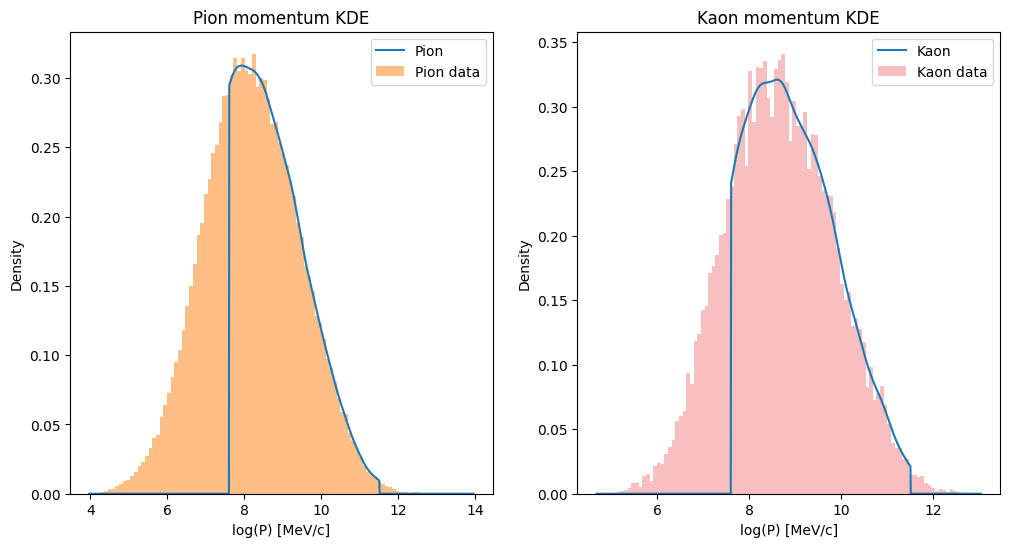

In [6]:
# Specify the momentum range for the KDE (one could not specify it and use all the range of the data + whatever the KDE has before going to zero)
momentum_trunc_range = (2000, 100000) # MeV/c below 2 GeV/c we are outside the RICH1 acceptance

MomentumType_complete = pd.DataFrame()
for i in range(len(df_c)):
    df_ci = df_c.loc[i]
    momentum_squared = df_ci['MCP_PX']**2 + df_ci['MCP_PY']**2 + df_ci['MCP_PZ']**2
    momentum = np.sqrt(momentum_squared)
    MomentumType_event = pd.DataFrame({'P': momentum, 'Type_ID': df_ci['MCP_ID']})    
    MomentumType_complete = pd.concat([MomentumType_complete, MomentumType_event], axis=0) #it's in MeV/c

# Generate a momentum (P) kde for each particle type (Type_ID)
log_kde_dict = {}
for particle_type in MomentumType_complete['Type_ID'].unique():
    particle_momentums = MomentumType_complete[MomentumType_complete['Type_ID'] == particle_type]['P']
    # Cut momentum range
    # particle_momentums = particle_momentums[(particle_momentums > momentum_range[0]) & (particle_momentums < momentum_range[1])]
    # Take the log for numerical stability (also add a small constant to avoid log(0))
    if len(particle_momentums) > 10:
        particle_momentums = np.log(particle_momentums + 1e-10)
        log_kde = TruncatedKDE(particle_momentums, truncate_range=(np.log(momentum_trunc_range[0]), np.log(momentum_trunc_range[1])))
        log_kde_dict[particle_type] = log_kde

# We plot the pion and kaon momentum KDEs as an example
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Pion (pdgid = 211)
x_pion = np.linspace(log_kde_dict[211].dataset.min()-0.2, log_kde_dict[211].dataset.max()+0.2, 1000)
ax[0].plot(x_pion, log_kde_dict[211](x_pion), label='Pion')
pion_momentums = MomentumType_complete[MomentumType_complete['Type_ID'] == 211]['P']
# pion_momentums = pion_momentums[(pion_momentums > momentum_range[0]) & (pion_momentums < momentum_range[1])]
pion_momentums = np.array(pion_momentums)
pion_momentums = np.log(pion_momentums + 1e-10)
ax[0].hist(pion_momentums, bins=100, density=True, alpha=0.5, label='Pion data')
ax[0].set_title('Pion momentum KDE')
ax[0].set_xlabel('log(P) [MeV/c]')
ax[0].set_ylabel('Density')
ax[0].legend()

# Kaon (pdgid = 321)
x_kaon = np.linspace(log_kde_dict[321].dataset.min()-0.2, log_kde_dict[321].dataset.max()+0.2, 1000)
ax[1].plot(x_kaon, log_kde_dict[321](x_kaon), label='Kaon')
kaon_momentums = MomentumType_complete[MomentumType_complete['Type_ID'] == 321]['P']
# kaon_momentums = kaon_momentums[(kaon_momentums > momentum_range[0]) & (kaon_momentums < momentum_range[1])]
kaon_momentums = np.array(kaon_momentums)
kaon_momentums = np.log(kaon_momentums + 1e-10)
ax[1].hist(kaon_momentums, bins=100, density=True, alpha=0.5, label='Kaon data', color='lightcoral')
ax[1].set_title('Kaon momentum KDE')
ax[1].set_xlabel('log(P) [MeV/c]')
ax[1].set_ylabel('Density')
ax[1].legend()


# Save the KDEs
for particle_type, kde in log_kde_dict.items():
    # remove everything after '.'
    kde_name = str(particle_type).split('.')[0]
    save_kde(kde, f'DatasetGeneration/distributions/log_momenta_kdes/{kde_name}-kde')

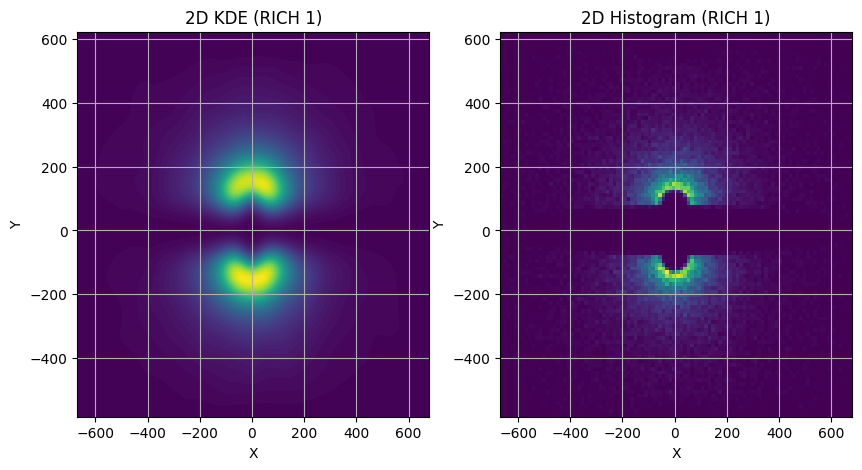

In [8]:
# computation of the centers distributions
# Get all centers in the data
all_centers_R1 = pd.DataFrame()
all_centers_R2 = pd.DataFrame()
for i in range(len(df_c)):
    df_ci = df_c.loc[i]
    centers_R1 = pd.DataFrame({'Ctr_xLoc_R1': df_ci['Ctr_xLoc_R1'], 'Ctr_yLoc_R1': df_ci['Ctr_yLoc_R1']})
    centers_R2 = pd.DataFrame({'Ctr_xLoc_R2': df_ci['Ctr_xLoc_R2'], 'Ctr_yLoc_R2': df_ci['Ctr_yLoc_R2']})
    all_centers_R1 = pd.concat([all_centers_R1, centers_R1], axis=0)
    all_centers_R2 = pd.concat([all_centers_R2, centers_R2], axis=0)

# Generate a 2D kde for the centers (one for RICH 1 and one for RICH 2)
kde_R1 = gaussian_kde(np.array(all_centers_R1).T) # Transpose the data to have the correct shape: (2, N)
kde_R2 = gaussian_kde(np.array(all_centers_R2).T)

data_2d = np.array(all_centers_R1).T

# Evaluate the KDE on a grid
x = np.linspace(data_2d[0].min(), data_2d[0].max(), 100)
y = np.linspace(data_2d[1].min(), data_2d[1].max(), 100)
X, Y = np.meshgrid(x, y)
grid_coords = np.vstack([X.ravel(), Y.ravel()])
Z = kde_R1(grid_coords).reshape(X.shape)

# Plot KDE contours and histogram in 2D (one adjecent to the other)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].contourf(X, Y, Z, levels=100, cmap='viridis')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('2D KDE (RICH 1)')
ax[0].grid()

ax[1].hist2d(data_2d[0], data_2d[1], bins=100, cmap='viridis')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_title('2D Histogram (RICH 1)')
ax[1].grid()

plt.show()

# save the 2D KDEs
save_kde(kde_R1, 'DatasetGeneration/distributions/centers_R1-kde')
save_kde(kde_R2, 'DatasetGeneration/distributions/centers_R2-kde')